In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy

### Import LDA document vectors

In [3]:
bow_stemmed_matrix = np.load('../../processed_files/bow_stemmed_matrix.npy')
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [4]:
bow_stemmed_matrix.shape

(12975, 4935)

In [5]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[0, -, m, y, ., c, o, m, , r, e, l, a, t, e, ..."
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[0, 1, 1, 8, 7, ., c, o, m, , i, s, , a, v, ..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[0, 2, 7, ., i, r, , -, , d, n, s, 4, ., i, ..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ..."


In [6]:
df_merged.shape

(12975, 4)

In [8]:
type(bow_stemmed_matrix[0])

scipy.sparse.csr.csr_matrix

## DB Scan

In [8]:
from sklearn.cluster import DBSCAN

In [9]:
# eps (default 0.5): the maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples (default 5): number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself
# algorithm (default 'auto'): ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
dbscan = DBSCAN(eps = 0.1, min_samples = 5).fit(bow_stemmed_matrix)

In [10]:
dbscan.labels_

array([-1,  0, -1, ..., -1, -1, -1])

In [11]:
num_clusters = max(dbscan.labels_)
num_clusters

37

In [12]:
dbscan

DBSCAN(eps=0.1)

In [13]:
index_cluster = zip(range(len(dbscan.labels_)), dbscan.labels_)
index_cluster_dict = dict(index_cluster)
index_cluster_dict[456]

-1

In [14]:
cluster_index = list(zip(dbscan.labels_, range(len(dbscan.labels_))))

In [48]:
cluster_list = dict()
for i in range(num_clusters):
    cluster_list[i] = list(filter(lambda row: row[0] == i, cluster_index))

In [49]:
for i in range(num_clusters):
    print('cluster: ', i, 'size: ', len(cluster_list[i]))

cluster:  0 size:  34
cluster:  1 size:  11
cluster:  2 size:  9
cluster:  3 size:  25
cluster:  4 size:  31
cluster:  5 size:  26
cluster:  6 size:  5
cluster:  7 size:  25
cluster:  8 size:  20
cluster:  9 size:  32
cluster:  10 size:  32
cluster:  11 size:  16
cluster:  12 size:  20
cluster:  13 size:  103
cluster:  14 size:  35
cluster:  15 size:  10
cluster:  16 size:  25
cluster:  17 size:  21
cluster:  18 size:  9
cluster:  19 size:  5
cluster:  20 size:  21
cluster:  21 size:  13
cluster:  22 size:  32
cluster:  23 size:  27
cluster:  24 size:  19
cluster:  25 size:  7
cluster:  26 size:  5
cluster:  27 size:  14
cluster:  28 size:  8
cluster:  29 size:  5
cluster:  30 size:  5
cluster:  31 size:  6
cluster:  32 size:  5
cluster:  33 size:  24
cluster:  34 size:  8
cluster:  35 size:  5
cluster:  36 size:  8


In [17]:
len(cluster_list[0])

34

In [18]:
len(cluster_list[1])

11

In [19]:
len(cluster_list[2])

9

In [20]:
len(cluster_list[num_clusters-1])

8

In [21]:
cluster_list[1]

[(1, 5),
 (1, 13),
 (1, 17),
 (1, 77),
 (1, 86),
 (1, 98),
 (1, 103),
 (1, 135),
 (1, 150),
 (1, 155),
 (1, 161)]

In [25]:
#print(clusters.labels_.shape)

In [26]:
[i[1] for i in cluster_list[0]]

[1,
 1859,
 2213,
 2445,
 2490,
 2581,
 2653,
 2682,
 2947,
 3148,
 3503,
 3921,
 4525,
 5549,
 5734,
 6273,
 6324,
 6610,
 6740,
 7724,
 7801,
 8708,
 9934,
 10336,
 10536,
 10621,
 10831,
 10905,
 11540,
 11818,
 12400,
 12468,
 12881,
 12947]

In [33]:
import statistics

# index is cluster index
def intracluster_similarity(index):
    cluster_centroid = np.average(bow_stemmed_matrix[[i[1] for i in cluster_list[index]]], axis=0)
    dist_list = []
    cluster = cluster_list[index]
    for i in cluster:
        distance = np.linalg.norm(cluster_centroid-bow_stemmed_matrix[i[1]])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)

    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    
    return avg, variance

In [36]:
intracluster_similarity(2)

(0.0, 0.0)

In [38]:
# index is cluster / cluster id
def generate_raw_content_cluster_df(index):
    index_list = cluster_list[index]
    index_list = [x[1] for x in index_list]
    cluster_seed = df_merged.loc[index].to_frame().T
    #cluster_df = df_merged.loc[index_list[1:]]
    cluster_df = df_merged.loc[index_list[1:]]
    combined = pd.concat([cluster_seed, cluster_df])
    combined['cluster'] = index
    return combined

In [50]:
generate_raw_content_cluster_df(10)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED,cluster
10,100coin.com,100coin.com 您正在访问的域名 (100coin.com) 可以合作或转让! th...,"[coincom, 您正在访问的域名, coincom, 可以合作或转让, domain, ...","[1, 0, 0, c, o, i, n, ., c, o, m, , 您, 正, 在, ...",10
826,archispecs.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
1128,badassmanship.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
1992,capitalsubsidy.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
2017,cardinalescrow.info,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
2068,casadragonestastingroom.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
2148,cellinnotherapeutics.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
2788,crystalcardconcierge.biz,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
3067,denisemerrill.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10
3963,facebookvs.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",10


In [51]:
avg_list = []
variance_list = []

for i in range(num_clusters):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x175cdea20>,
 <a list of 11 Text xticklabel objects>)

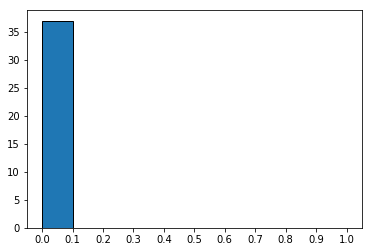

In [52]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

## Intercluster Similarity

In [53]:
def intercluster_dist():
    indices = range(num_clusters)
    centroid_centroid_distance = {}
    values = []
    for i in indices:
        for j in indices:
            if i < j:
                key = str(i) + "::" + str(j)
                cluster_centroid_i = np.average(bow_stemmed_matrix[[x[1] for x in cluster_list[i]]], axis=0)
                cluster_centroid_j = np.average(bow_stemmed_matrix[[x[1] for x in cluster_list[j]]], axis=0)
                distance = np.linalg.norm(cluster_centroid_i - cluster_centroid_j)
                centroid_centroid_distance[key] = distance
                values.append(distance)
    return centroid_centroid_distance, values

In [54]:
intercluster_distances, values = intercluster_dist()
#print('distances', values)
print('average', np.average(values))

average 141.61901121847353
